# Testing the model on another dataset (CIC 2019)

In [1]:
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, mutual_info_classif, chi2
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Reading the file
cic_df=pd.read_csv('preProcessed_FeatureClean_AttackTypes.csv', index_col=0)

# Renaming columns to match the model
rename_column =  {'Packet Length Max': 'Max Packet Length',
                  'Init Fwd Win Bytes':'Init_Win_bytes_forward',
                  'Bwd Packets Length Total':'Total Length of Bwd Packets',
                  'Packet Length Min':'Min Packet Length',
                  'Fwd Seg Size Min':'min_seg_size_forward',
                  'Fwd Act Data Packets':'act_data_pkt_fwd',
                  'Avg Packet Size':'Average Packet Size',
                  'Init Bwd Win Bytes':'Init_Win_bytes_backward',
                  'Fwd Packets Length Total':'Total Length of Fwd Packets'
                }
cic_df = cic_df.rename(columns=rename_column)
cic_df.head()

,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
Source Port,,,,,,,,,,,,,,,,,,,,,
60675,80,6,5220876,12,9,1928.0,4290.0,509.0,0.0,160.666667,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,4
60676,80,6,12644252,5,2,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,4
443,50458,6,3,2,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,0
443,50465,6,3,2,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,0
0,0,0,114329232,52,0,0.0,0.0,0.0,0.0,0.000000,...,7.416667,2.466441,15.0,6.0,9527428.0,248706.681286,9950741.0,9092248.0,0,0


In [3]:
cic_df.columns

Index(['Destination Port', 'Protocol', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'ACK Flag Count',
       'URG Flag Count', 'CWE Flag Count', 'Down/Up Ratio',
     

In [4]:
cic_df.dtypes

Destination Port                 int64
Protocol                         int64
Flow Duration                    int64
Total Fwd Packets                int64
Total Backward Packets           int64
Total Length of Fwd Packets    float64
Total Length of Bwd Packets    float64
Fwd Packet Length Max          float64
Fwd Packet Length Min          float64
Fwd Packet Length Mean         float64
Fwd Packet Length Std          float64
Bwd Packet Length Max          float64
Bwd Packet Length Min          float64
Bwd Packet Length Mean         float64
Bwd Packet Length Std          float64
Flow Bytes/s                   float64
Flow Packets/s                 float64
Flow IAT Mean                  float64
Flow IAT Std                   float64
Flow IAT Max                   float64
Flow IAT Min                   float64
Fwd IAT Total                  float64
Fwd IAT Mean                   float64
Fwd IAT Std                    float64
Fwd IAT Max                    float64
Fwd IAT Min              

In [5]:
zero_count = (cic_df['Label'] == 0).sum()
print("Number of zeros:", zero_count)

Number of zeros: 21377


In [6]:
# Drop any rows with nulls
cic_df = cic_df.drop(index=cic_df[cic_df.isnull().any(axis=1)].index)

# Drop any rows with infinity
cic_df = cic_df.drop(index=cic_df[cic_df.isin([np.inf, -np.inf]).any(axis=1)].index)

# Change flags to boolean type
to_bool = []
for x in cic_df.columns:
    if "Flag" in x:
        to_bool.append(x)
cic_df[to_bool] = cic_df[to_bool].astype('bool')

# Changing Label to 0 and 1
cic_df['Label'] = cic_df['Label'].apply(lambda x: 0 if x == 0 else 1)
cic_df['Label'] = cic_df['Label'].astype('bool')

# Separating features from target
X_cic = cic_df.drop(columns=['Label'])
y_cic = cic_df['Label']

In [7]:
zero_count = (cic_df['Label'] == 0).sum()
print("Number of zeros:", zero_count)

Number of zeros: 21377


In [8]:
cic_df.head()

,Destination Port,Protocol,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,...,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Inbound,Label
Source Port,,,,,,,,,,,,,,,,,,,,,
60675,80,6,5220876,12,9,1928.0,4290.0,509.0,0.0,160.666667,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,True
60676,80,6,12644252,5,2,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,True
443,50458,6,3,2,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,False
443,50465,6,3,2,0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,1,False
0,0,0,114329232,52,0,0.0,0.0,0.0,0.0,0.000000,...,7.416667,2.466441,15.0,6.0,9527428.0,248706.681286,9950741.0,9092248.0,0,False


In [10]:
cic_df.shape

(9554688, 60)

## Logistic Regression Model

### random search

              precision    recall  f1-score   support

       False       0.41      0.97      0.58     97831
        True       0.98      0.60      0.74    333540

    accuracy                           0.68    431371
   macro avg       0.70      0.78      0.66    431371
weighted avg       0.85      0.68      0.71    431371



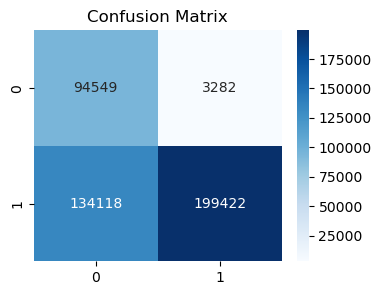

In [51]:
with open('model_1_logreg_randomsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

In [34]:
loaded_model_pickle.best_params_

{'prediction__C': 7.915074397656213,
 'prediction__l1_ratio': 0.6371651421518383,
 'preprocessing__cat_processing__select_k__k': 1}

### grid search

In [11]:
with open('model_1_logreg_gridsearch.pkl', 'rb') as file:
    loaded_model_pickle = pickle.load(file)

prediction_cic = loaded_model_pickle.best_estimator_.predict(X_cic)
print(classification_report(y_cic, prediction_cic))
conf_mat = confusion_matrix(y_cic, prediction_cic)
plt.figure(figsize=(4,3))
sns.heatmap(conf_mat, cmap='Blues', annot=True, fmt='2')
plt.title('Confusion Matrix')
plt.show()

ValueError: columns are missing: {'SYN Flag Count', 'PSH Flag Count'}